<h1 style="font-family: Georgia; font-size:3em;color:#2462C0; font-style:bold">
Coding Neural Network - Parameters' Initialization
</h1><br>

<p align="center">
<img src="images/parameters_init.png" style="height:400px; width:600px">
</p>
Optimization, in Machine Learning/Deep Learning contexts, is the process of changing the model's weights to improve its performance. In other words, it's the process of finding the best weights in the predefined hypothesis space to get the best possible performance. There are three kinds of optimization algorithms:
- Optimization algorithm that is not iterative and simply solves for one point.
- Optimization algorithm that is iterative in nature and converges to acceptable solution regardless of the parameters initialization such as gradient descent applied to logistic regression.
- Optimization algorithm that is iterative in nature and applied to a set of problems that have non-convex loss functions such as neural networks. Therefore, parameters' initialization plays a critical role in speeding up convergence and achieving lower error rates.

In this notebook, we'll look at three different cases of parameters' initialization and see how this affects the error rate:
- Initialize all weights to zero.
- Initialize weights to random values from standard normal distribution or uniform distribution and multiply it by a scalar such as 10.
- Initialize weights based on:
    - Xavier recommendation.
    - Kaiming He recommendation.
    
We'll be using functions we wrote in [*"Coding Neural Network - Forward Propagation and Backpropagation"*](https://nbviewer.jupyter.org/github/ImadDabbura/blog-posts/blob/master/notebooks/Coding-Neural-Network-Forwad-Back-Propagation.ipynb) notebook to initialize parameters, compute forward propagation and back-propagation as well as the cross-entropy cost.

To illustrate the above cases, we'll use the cats vs dogs dataset which consists of 50 images for cats and 50 images for dogs. Each image is 150 pixels x 150 pixels on RGB color scale. Therefore, we would have 67,500 features where each column in the input matrix would be one image which means our input data would have 67,500 x 100 dimension.

Let's first load the data and show a sample of two images before we start the helper functions.

In [1]:
# Loading packages
import sys

import h5py
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sys.path.append("../scripts/")
from coding_neural_network_from_scratch import (L_model_forward,
                                                compute_cost,
                                                L_model_backward,
                                                update_parameters,
                                                accuracy)
from load_dataset import load_dataset_catvsdog

%matplotlib inline
sns.set_context("notebook")
plt.style.use("fivethirtyeight")

C:\Users\e739218\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


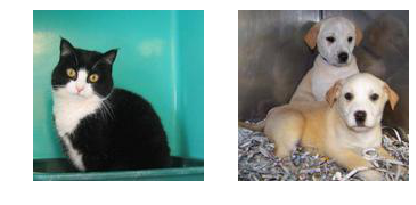

In [2]:
X, Y = load_dataset_catvsdog("../data")

# show a sample of of a cat and a dog image
index_cat = np.argmax(Y); index_dog = np.argmin(Y)
plt.subplot(1, 2, 1)
plt.imshow(X[:, index_cat].reshape(150, 150, 3))
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(X[:, index_dog].reshape(150, 150, 3))
plt.axis("off");

# standarize the data
X = X / 255

We'll write now all the helper functions that will help us initialize weights based on different methods as well as writing L-layer model that we'll be using to train our neural network.

In [3]:
def initialize_parameters_zeros(layers_dims):
    """
    Initializes the parameters dictionary to all zeros for both weights and
    bias.

    Arguments
    ---------
    layer_dims : list
        input size and size of each layer, length: number of layers + 1.

    Returns
    -------
    parameters : dict
        weight matrix and the bias vector for each layer.
    """
    np.random.seed(1)               
    parameters = {}                 
    L = len(layers_dims)            

    for l in range(1, L):
        parameters["W" + str(l)] = np.zeros(
            (layers_dims[l], layers_dims[l - 1]))
        parameters["b" + str(l)] = np.zeros((layers_dims[l], 1))

    return parameters


def initialize_parameters_random(layers_dims):
    """
    Initializes the parameters dictionary rabdomly from standard normal
    distribution multiplied by 10 for weight matrices and zeros for bias
    vectors.

    Arguments
    ---------
    layer_dims : list
        input size and size of each layer, length: number of layers + 1.

    Returns
    -------
    parameters : dict
        weight matrix and the bias vector for each layer.
    """
    np.random.seed(1)               
    parameters = {}                 
    L = len(layers_dims)            

    for l in range(1, L):
        parameters["W" + str(l)] = np.random.randn(
            layers_dims[l], layers_dims[l - 1]) * 10
        parameters["b" + str(l)] = np.zeros((layers_dims[l], 1))

    return parameters


def initialize_parameters_he_xavier(layers_dims, initialization_method="he"):
    """
    Initializes the parameters dictionary for weights based on "He" and
    "Xavier" methods and zeros for bias vectors.

    Arguments
    ---------
    layer_dims : list
        input size and size of each layer, length: number of layers + 1.
    initialization_method : str
        specify the initialization method to be used: "he", "xavier".

    Returns
    -------
    parameters : dict
        weight matrix and the bias vector for each layer.
    """
    np.random.seed(1)               
    parameters = {}                 
    L = len(layers_dims)            

    if initialization_method == "he":
        for l in range(1, L):
            parameters["W" + str(l)] = np.random.randn(
                layers_dims[l],
                layers_dims[l - 1]) * np.sqrt(2 / layers_dims[l - 1])
            parameters["b" + str(l)] = np.zeros((layers_dims[l], 1))
    elif initialization_method == "xavier":
        for l in range(1, L):
            parameters["W" + str(l)] = np.random.randn(
                layers_dims[l],
                layers_dims[l - 1]) * np.sqrt(1 / layers_dims[l - 1])
            parameters["b" + str(l)] = np.zeros((layers_dims[l], 1))

    return parameters


In [4]:
def model(X, Y, layers_dims, learning_rate=0.01, num_iterations=1000,
          print_cost=True, hidden_layers_activation_fn="relu",
          initialization_method="he"):
    """
    Implements multilayer neural network using gradient descent as the
    learning algorithm.

    Arguments
    ---------
    X : 2d-array
        data, shape: number of examples x num_px * num_px * 3.
    y : 2d-array
        true "label" vector, shape: 1 x number of examples.
    layers_dims : list
        input size and size of each layer, length: number of layers + 1.
    learning_rate : float
        learning rate of the gradient descent update rule.
    num_iterations : int
        number of iterations of the optimization loop.
    print_cost : bool
        if True, it prints the cost every 100 steps.
    hidden_layers_activation_fn : str
        activation function to be used on hidden layers: "tanh", "relu".
    initialization_method : str
        specify the initialization method to be used: "he", "xavier".

    Returns
    -------
    parameters : dict
        parameters learnt by the model. They can then be used to predict test
        examples.
    """
    np.random.seed(1)

    # initialize cost list
    cost_list = []

    # initialize parameters
    if initialization_method == "zeros":
        parameters = initialize_parameters_zeros(layers_dims)
    elif initialization_method == "random":
        parameters = initialize_parameters_random(layers_dims)
    else:
        parameters = initialize_parameters_he_xavier(
            layers_dims, initialization_method)

    # iterate over num_iterations
    for i in range(num_iterations):
        # iterate over L-layers to get the final output and the cache
        AL, caches = L_model_forward(
            X, parameters, hidden_layers_activation_fn)

        # compute cost to plot it
        cost = compute_cost(AL, Y)

        # iterate over L-layers backward to get gradients
        grads = L_model_backward(AL, Y, caches, hidden_layers_activation_fn)

        # update parameters
        parameters = update_parameters(parameters, grads, learning_rate)

        # append each 100th cost to the cost list
        if (i + 1) % 100 == 0 and print_cost:
            print("The cost after {} iterations is: {}".format(i + 1, cost))

        if i % 100 == 0:
            cost_list.append(cost)

    # plot the cost curve
    plt.figure(figsize=(12, 8))
    plt.plot(cost_list)
    plt.xlabel("Iterations (per hundreds)", fontsize=14)
    plt.ylabel("Cost", fontsize=14)
    plt.title(
        "Cost curve: learning rate = {} and {} initialization method".format(
            learning_rate, initialization_method), y=1.05, fontsize=16)

    return parameters


<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Initializing all weights to zero
</h2>

Here, we'll initialize all weight matrices and biases to zeros and see how this would affect the error rate as well as the learning parameters.

The cost after 100 iterations is: 0.6931471805599453
The cost after 200 iterations is: 0.6931471805599453
The cost after 300 iterations is: 0.6931471805599453
The cost after 400 iterations is: 0.6931471805599453
The cost after 500 iterations is: 0.6931471805599453
The cost after 600 iterations is: 0.6931471805599453
The cost after 700 iterations is: 0.6931471805599453
The cost after 800 iterations is: 0.6931471805599453
The cost after 900 iterations is: 0.6931471805599453
The cost after 1000 iterations is: 0.6931471805599453


'The accuracy rate is: 50.00%.'

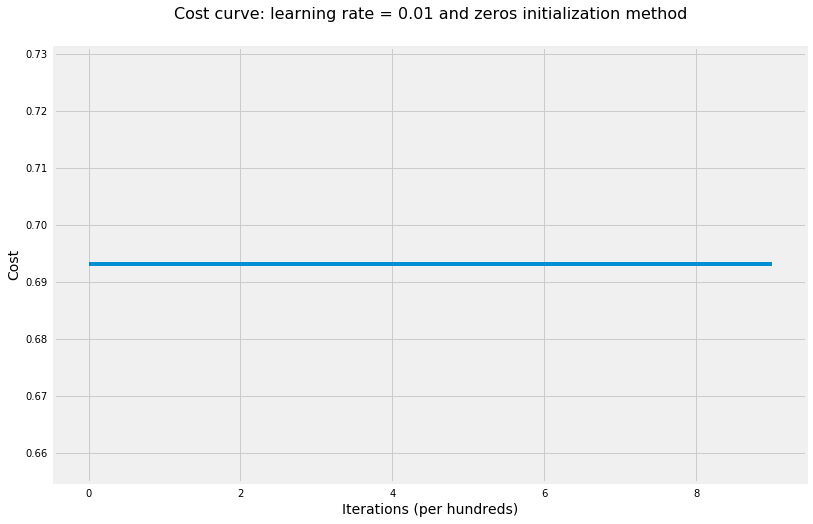

In [5]:
# train NN with zeros initialization weights
layers_dims = [X.shape[0], 5, 5, 1]
parameters = model(X, Y, layers_dims, hidden_layers_activation_fn="tanh",
                   initialization_method="zeros")

accuracy(X, parameters, Y,"tanh")

As the cost curve shows, the neural network didn't learn anything! That is because of symmetry between all neurons which leads to all neurons have the same update on every iteration. Therefore, regardless of how many iterations we run the optimization algorithms, all the neurons would still get the same update and no learning would happen. As a result, we must **break symmetry** when initializing weights so that the model would start learning on each update of the gradient descent.

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Initializing weights with big random values
</h2>

There is no big difference if the random values are initialized from standard normal distribution or uniform distribution so we'll use standard normal distribution in our examples. Also, we'll multiply the random values by a big number such as 10 to show that initializing weights to big values may cause our optimization to have higher error rates (and even diverge in some cases). Let's now train our neural network where all weight matrices have been intitialized using the following formula:
`np.random.randn() * 10`

The cost after 100 iterations is: 1.2413142077549013
The cost after 200 iterations is: 1.1258751902393416
The cost after 300 iterations is: 1.0989052435267657
The cost after 400 iterations is: 1.0840966471282327
The cost after 500 iterations is: 1.0706953292105978
The cost after 600 iterations is: 1.0574847320236294
The cost after 700 iterations is: 1.0443168708889223
The cost after 800 iterations is: 1.031157857251139
The cost after 900 iterations is: 1.0179838815204902
The cost after 1000 iterations is: 1.004767088515343


'The accuracy rate is: 55.00%.'

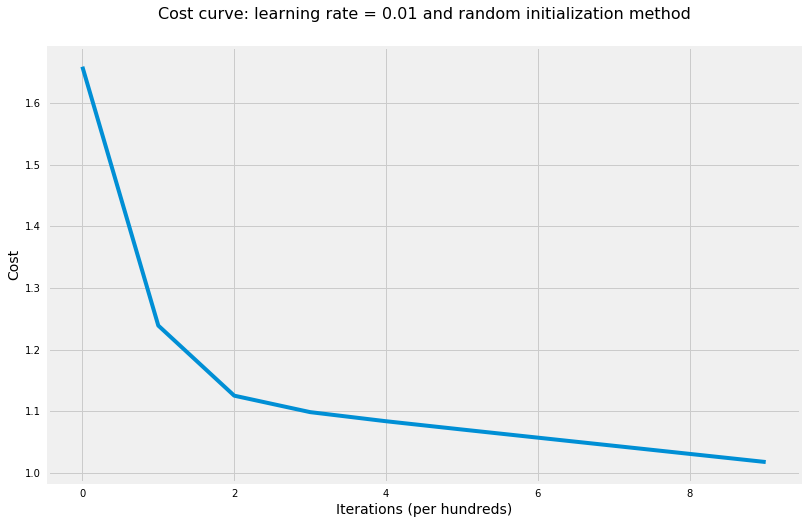

In [6]:
# train NN with random initialization weights
layers_dims = [X.shape[0], 5, 5, 1]
parameters = model(X, Y, layers_dims, hidden_layers_activation_fn="tanh",
                   initialization_method="random")

accuracy(X, parameters, Y,"tanh")

Random initialization here is helping but still the loss function has high value and may take long time to converge and achieve a significantly low value.

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Initializing weights based on He and Xavier recommendations
</h2>

We'll explore two initialization methods:
- Kaiming He method is best applied when activation function applied on hidden layers is Rectified Linear Unit (ReLU). so that the weight on each hidden layer would have the following variance: $$var(W^l) = \frac{2}{n^{l - 1}}$$
We can achieve this by multiplying the random values from standard normal distribution by $\sqrt{\frac{2}{number\ of\ units\ in \ previous\ layer}}$
- Xavier method is best applied when activation function applied on hidden layers is Hyperbolic Tangent so that the weight on each hidden layer would have the following variance: $$var(W^l) = \frac{1}{n^{l - 1}}$$
We can achieve this by multiplying the random values from standard normal distribution by $\sqrt{\frac{1}{number\ of\ units\ in \ previous\ layer}}$

We'll train the network using both methods and look at the results.

The cost after 100 iterations is: 0.6300611704834093
The cost after 200 iterations is: 0.49092836452522753
The cost after 300 iterations is: 0.46579423512433943
The cost after 400 iterations is: 0.6516254192289226
The cost after 500 iterations is: 0.32487779301799485
The cost after 600 iterations is: 0.4631461605716059
The cost after 700 iterations is: 0.8050310690163623
The cost after 800 iterations is: 0.31739195517372376
The cost after 900 iterations is: 0.3094592175030812
The cost after 1000 iterations is: 0.19934509244449203


'The accuracy rate is: 99.00%.'

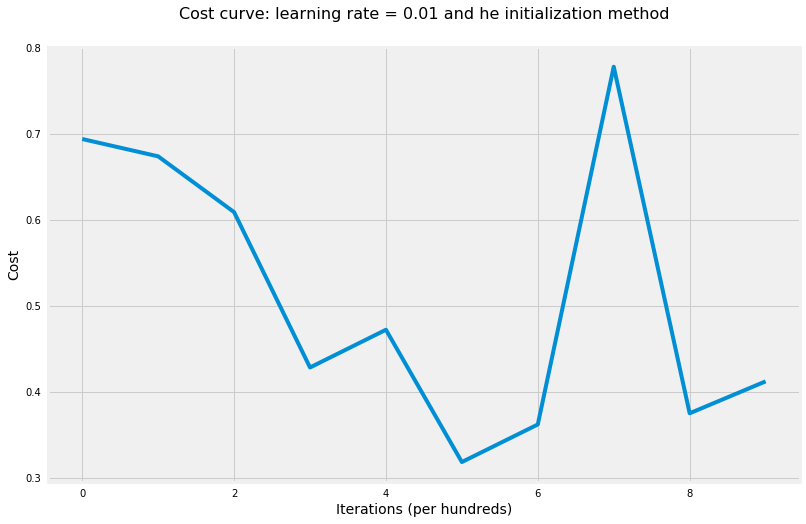

In [7]:
# train NN where all weights were initialized based on He recommendation
layers_dims = [X.shape[0], 5, 5, 1]
parameters = model(X, Y, layers_dims, hidden_layers_activation_fn="tanh",
                   initialization_method="he")

accuracy(X, parameters, Y, "tanh")

The cost after 100 iterations is: 0.6351961521800779
The cost after 200 iterations is: 0.548973489787121
The cost after 300 iterations is: 0.47982386652748565
The cost after 400 iterations is: 0.32811768889968684
The cost after 500 iterations is: 0.2793453045790634
The cost after 600 iterations is: 0.3258507563809604
The cost after 700 iterations is: 0.2873032724176074
The cost after 800 iterations is: 0.0924974839405706
The cost after 900 iterations is: 0.07418011931058155
The cost after 1000 iterations is: 0.06204402572328295


'The accuracy rate is: 99.00%.'

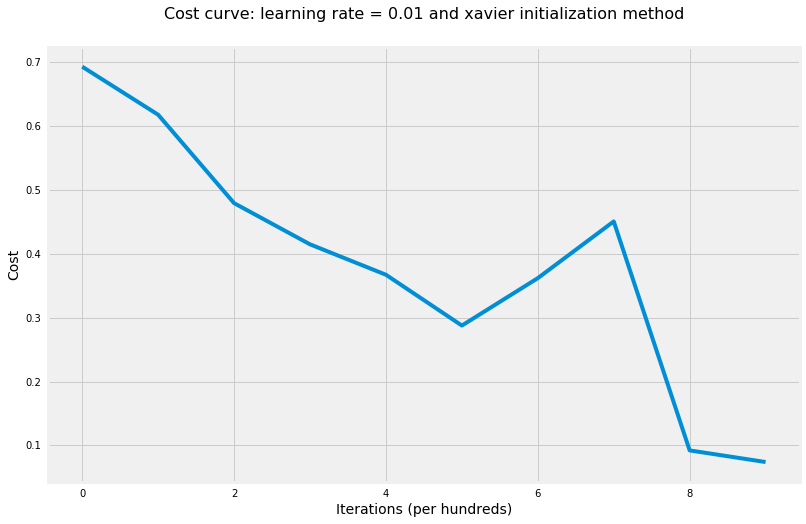

In [8]:
# train NN where all weights were initialized based on Xavier recommendation
layers_dims = [X.shape[0], 5, 5, 1]
parameters = model(X, Y, layers_dims, hidden_layers_activation_fn="tanh",
                   initialization_method="xavier")

accuracy(X, parameters, Y, "tanh")

As shown from applying the four methods, parameters' initial values play a huge role in achieving low cost values as well as converging and achieve lower training error rates. The same would apply to test error rate if we had test data.

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Conclusion
</h2>

Deep Learning frameworks make it easier to choose between different initialization methods without worrying about implementing it ourselves. Nonetheless, it's important to understand the critical role initial values of the parameters in the overall performance of the network. Below are some key takeaways:
- Well chosen initialization values of weights leads to:
    - Speed up convergence of gradient descent.
    - Increase the likelihood of gradient descent to find lower training and generalization error rates.
- Because we're dealing with iterative optimization algorithms with non-convex loss function, different initializations lead to different results.
- Random initialization is used to break symmetry and make sure different hidden units can learn different things.
- Don't initialize to values that are too large.
- Kaiming He (He) initialization works well for neural networks with ReLU activation function.
- Xavier initialization works well for neural networks with Hyperbolic Tangent activation function.